In [2]:
import matplotlib.pyplot as plt
import numpy as np

Here, we expand on the Monte Carlo simulation in airfare_dynamics_intro.ipynb to better reflect real-life scenarios. Each fare bucket has a base demand curve based on the days until the flight departs. From this base demand curve, we construct exponential demand functions for each of the fare buckets, with more price sensitivity for the cheaper-fare tickets, based on the prices for each of those tickets. Additionally, the prices for each of the fare buckets move dynamically as more or less tickets sell each day than expected. Demand for each ticket then moves accordingly.

In [3]:
# Different base demand curve functions:

def linear(a, b, x):
    return a + b * x

def convex(a, b, c, x):
    return a + b * (x ** c)

def bell(a, mu, sigma, x):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

We perform this analysis by assuming a Gaussian base demand for each ticket type. We make the assumption that demand for the cheaper fare buckets spike a long time before the departure date, while demand for the more expensive tickets spike closer to the departure date. 

In [23]:
# Parameters
days_to_departure = 30
num_customers_per_day = 100
num_trials = 1000
alpha = 0.005  # price adjustment sensitivity

#Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 250,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(120, 8, 15, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 300,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(90, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 500,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(50, 20, 7, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 800,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(25, 23, 5, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
seats_sold_per_day = [[0 for _ in range(days_to_departure)] for _ in range(len(base_fare_buckets))]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial

# --- Demand Function ---
def purchase_probability(demand, price, elasticity):
    demand_at_price = demand * np.exp(-elasticity * price)
    return min(1.0, demand_at_price)

# --- Price Adjustment ---
def adjust_price(bucket, actual, expected):
    if expected == 0:
        return
    pressure = actual / expected
    if pressure > 1.05:
        bucket["price"] *= 1 + alpha * np.log(pressure)
        bucket["price_increases"] += 1
    elif pressure < 0.75:
        bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))

# --- Single Simulation ---
def run_simulation(track_prices=False):
    fare_buckets = []
    for b in base_fare_buckets:
        fare_buckets.append({
            **b,
            "sold": 0,
            "revenue": 0,
            "price": b["base_price"],
            "price_increases": 0
        })

    if track_prices:
        local_price_paths = [[] for _ in base_fare_buckets]
        local_demand_paths = [[] for _ in base_fare_buckets]
        for i, bucket in enumerate(fare_buckets):
            local_price_paths[i].append(bucket["price"])
            local_demand_paths[i].append(bucket["base_demand_curve"][0]) 


    for day in range(days_to_departure):
        for i, bucket in enumerate(fare_buckets):
            # Calculate base demand for this day
            base_demand_today = bucket["base_demand_curve"][day]

            if bucket["sold"] >= bucket["capacity"]:
                if track_prices:
                    # Calculate demand using exponential function based on price and elasticity
                    demand = base_demand_today * np.exp(-bucket["elasticity"] * bucket["price"])
                    local_price_paths[i].append(bucket["price"])
                    local_demand_paths[i].append(demand)
                continue

            total_sold_today = 0
            # Calculate base demand for this day
            base_demand_today = bucket["base_demand_curve"][day]

            for _ in range(num_customers_per_day):

                if bucket["sold"] >= bucket["capacity"]:
                    break

                # Calculate purchase probability using base demand, price, elasticity, and capacity
                prob = purchase_probability(base_demand_today, bucket["price"], bucket["elasticity"])

                expected_sold = num_customers_per_day * prob

                if np.random.rand() < prob:
                    bucket["sold"] += 1
                    total_sold_today += 1
                    bucket["revenue"] += bucket["price"]
                    
            # Adjust price based on actual vs expected fill on the day
            adjust_price(bucket, total_sold_today, expected_sold)

            if track_prices:
                # Calculate demand using exponential function based on price and elasticity
                demand = base_demand_today * np.exp(-bucket["elasticity"] * bucket["price"])
                local_price_paths[i].append(bucket["price"])
                local_demand_paths[i].append(demand)

    # Save outputs
    total_revenue = sum(b["revenue"] for b in fare_buckets)
    total_revenues.append(total_revenue)

    for i, b in enumerate(fare_buckets):
        fare_sales_all_trials[i].append(b["sold"])
        fare_revenues_all_trials[i].append(b["revenue"])

    if track_prices:
        for i in range(num_buckets):
            price_paths_example_trial[i] = local_price_paths[i]
            demand_paths_example_trial[i] = local_demand_paths[i]

In [24]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_1232/1457845257.py:64: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $37034.46
Median Revenue: $37026.03
Std Dev Revenue: $30.39

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 40.00, Avg Revenue = $10001.08
Economy Flex: Avg Tickets Sold = 30.00, Avg Revenue = $9000.00
Premium: Avg Tickets Sold = 20.00, Avg Revenue = $10019.50
Business: Avg Tickets Sold = 10.00, Avg Revenue = $8013.88


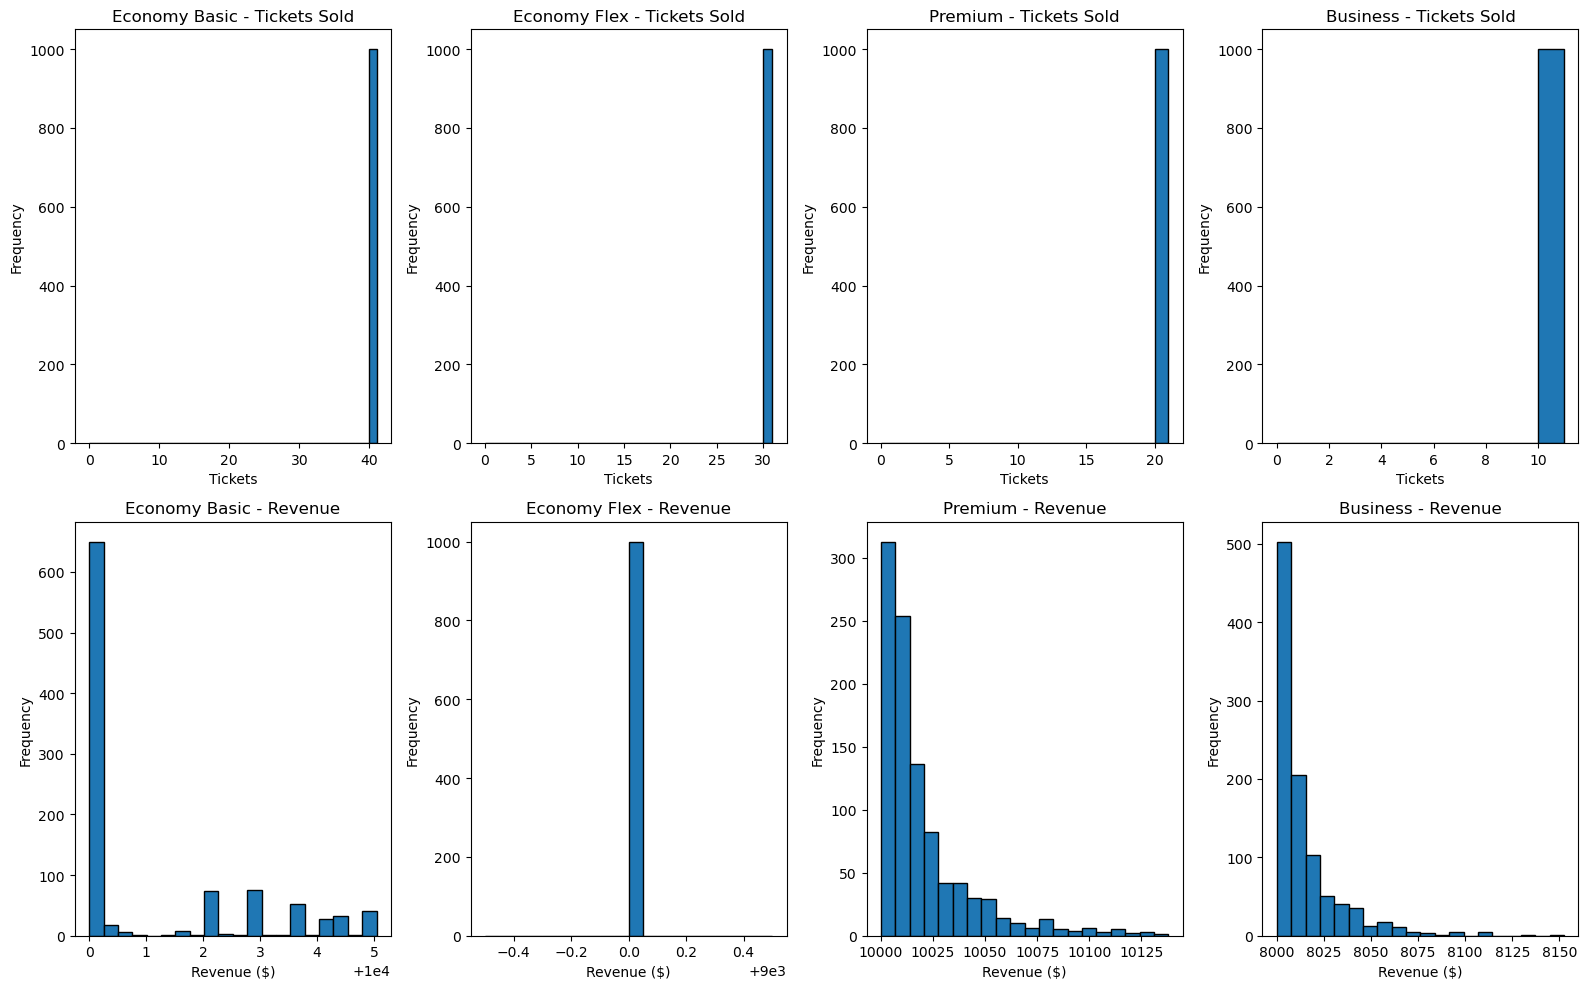

In [25]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_1.png")
plt.show()

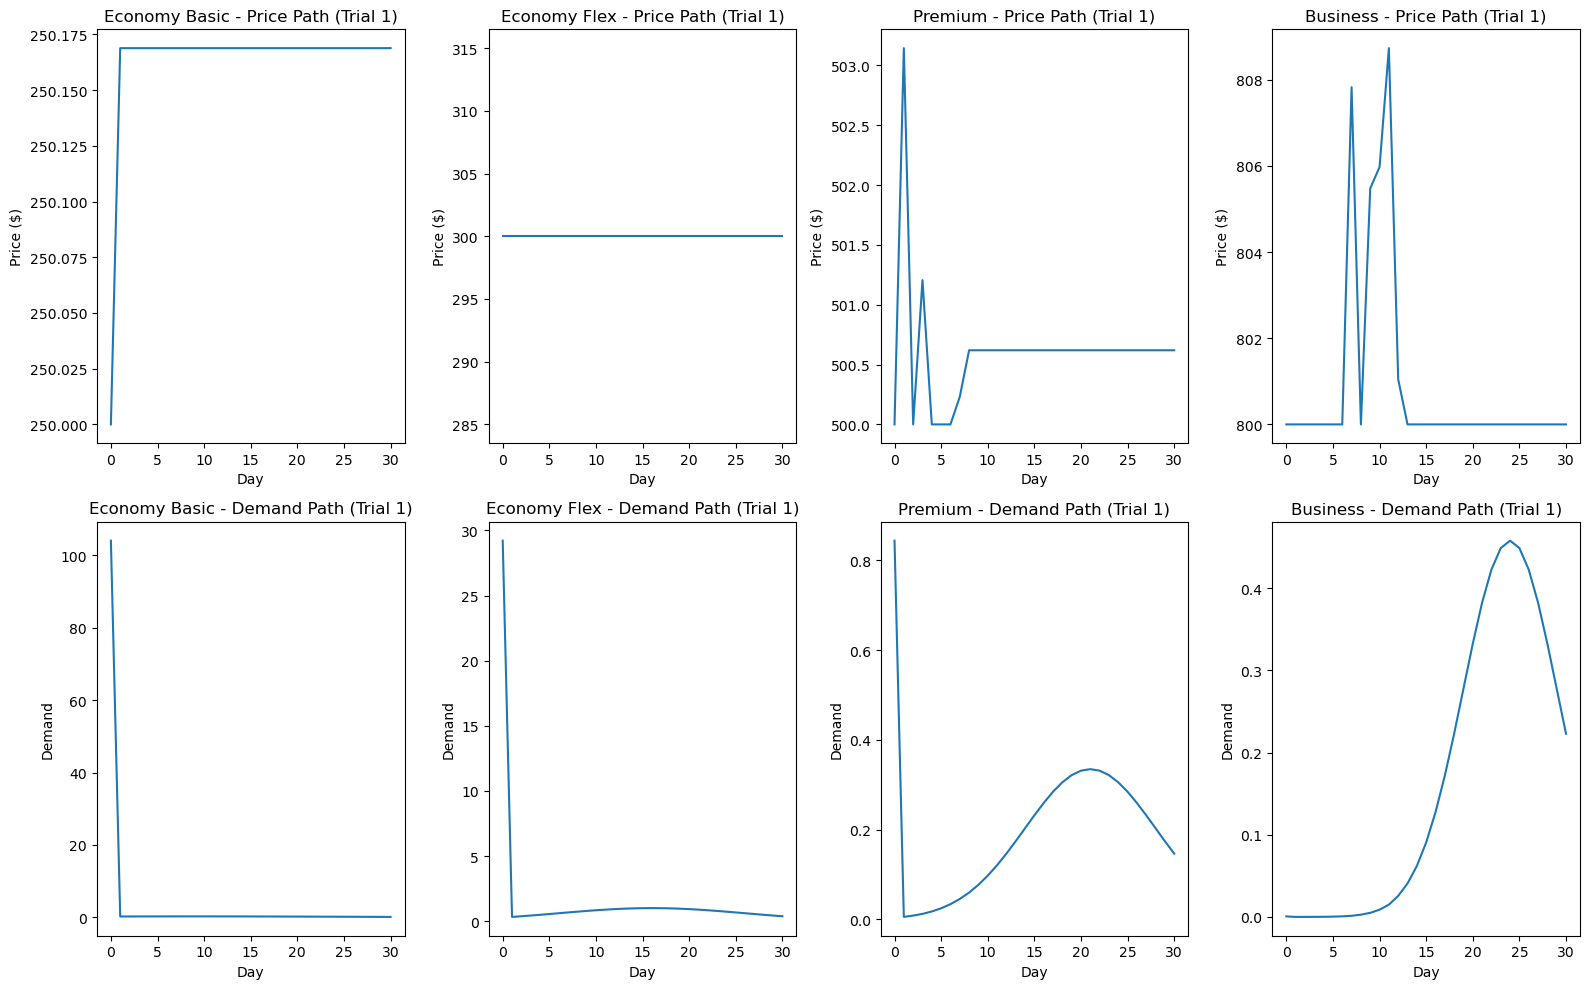

In [26]:
# --- Plot Price and Demand Paths for 1st Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")
plt.tight_layout()
plt.savefig("price_demand_paths_1.png")
plt.show()

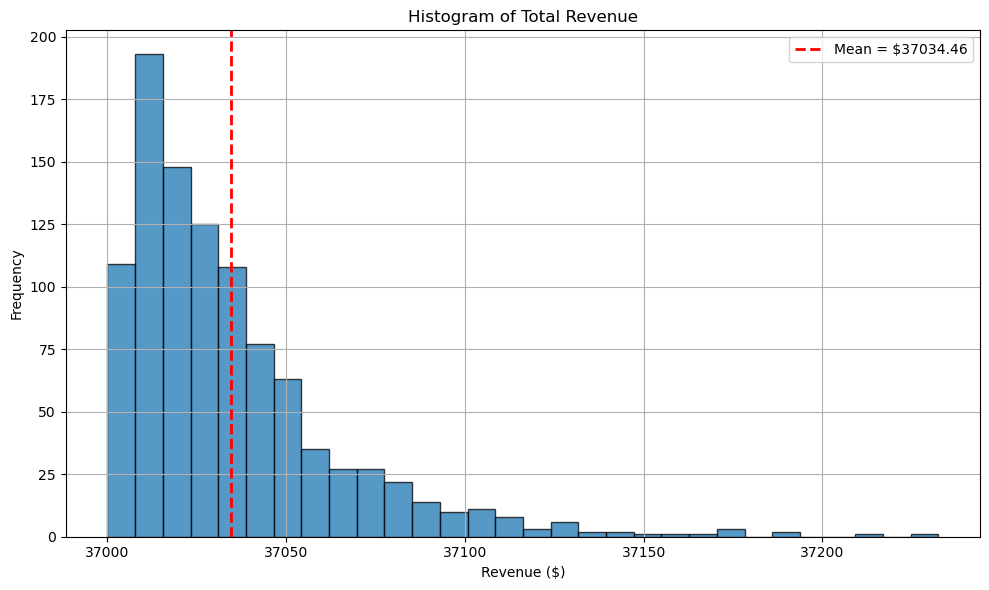

In [27]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_1.png")
plt.show()

From the experiment above, we can see that all of tickets are selling out every trial, indicating that the initial prices for each ticket are too low. To solve this, we will try increasing the initial prices for all of the fare buckets.

In [63]:
#Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 355,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(120, 8, 15, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 585,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(90, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 825,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(50, 20, 7, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 1615,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(25, 23, 5, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
seats_sold_per_day = [[0 for _ in range(days_to_departure)] for _ in range(len(base_fare_buckets))]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial


In [64]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_1232/1457845257.py:64: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $57882.34
Median Revenue: $58615.53
Std Dev Revenue: $4462.27

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 37.46, Avg Revenue = $13324.54
Economy Flex: Avg Tickets Sold = 27.61, Avg Revenue = $16198.50
Premium: Avg Tickets Sold = 18.54, Avg Revenue = $15333.39
Business: Avg Tickets Sold = 8.05, Avg Revenue = $13025.91


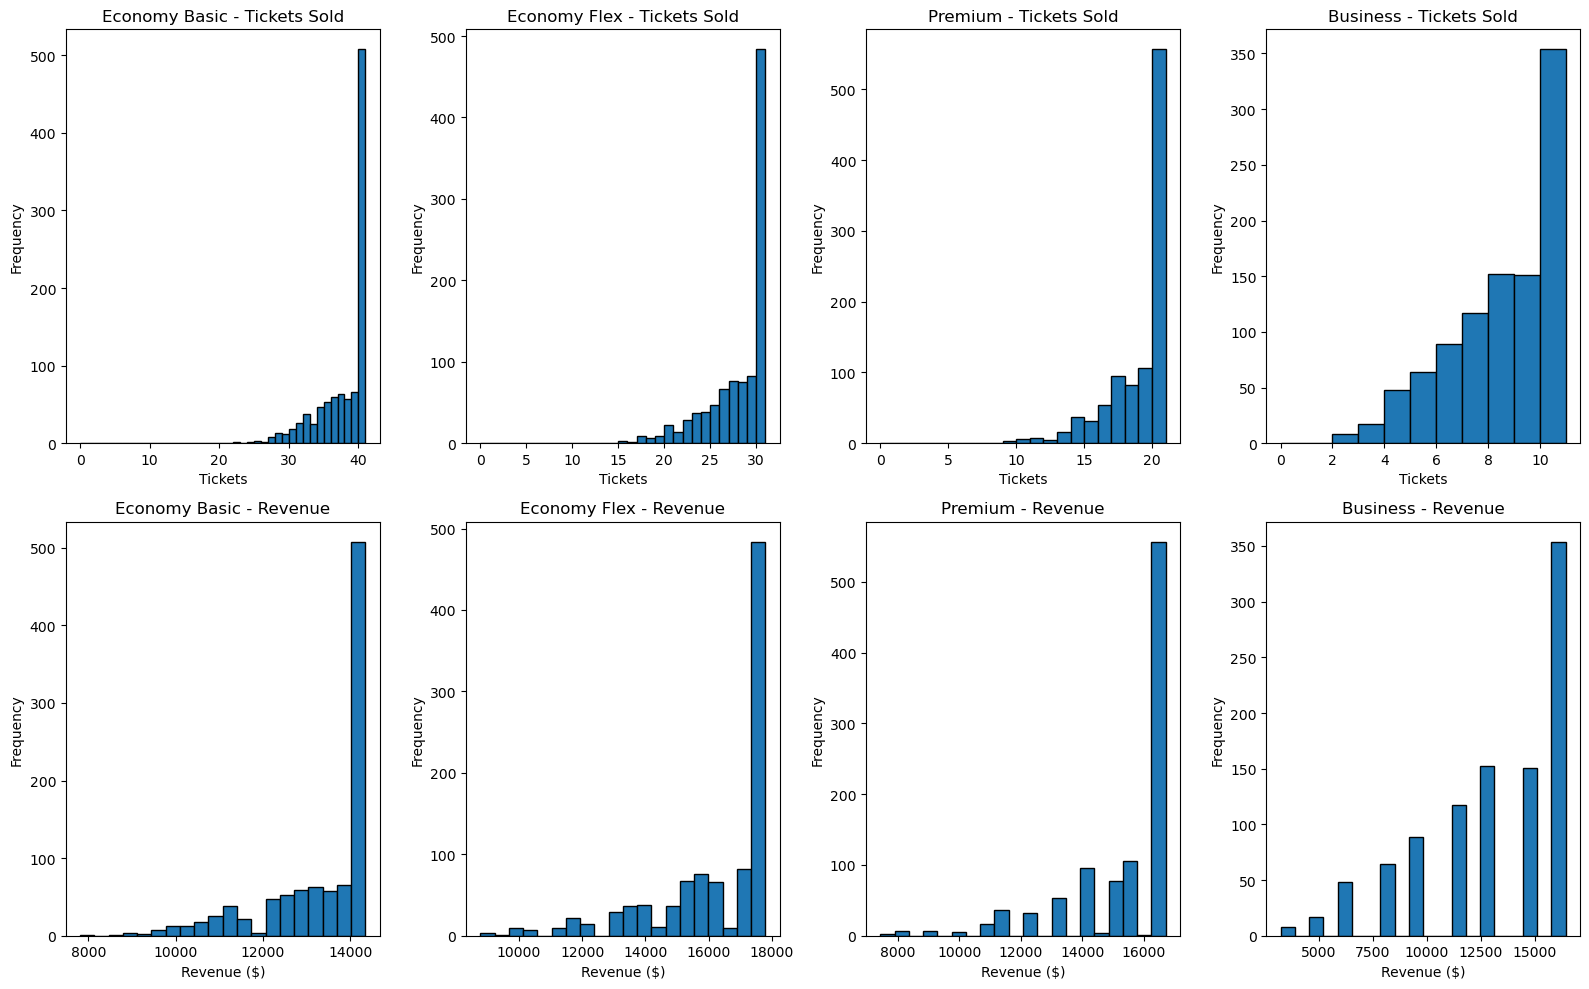

In [65]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_2.png")
plt.show()

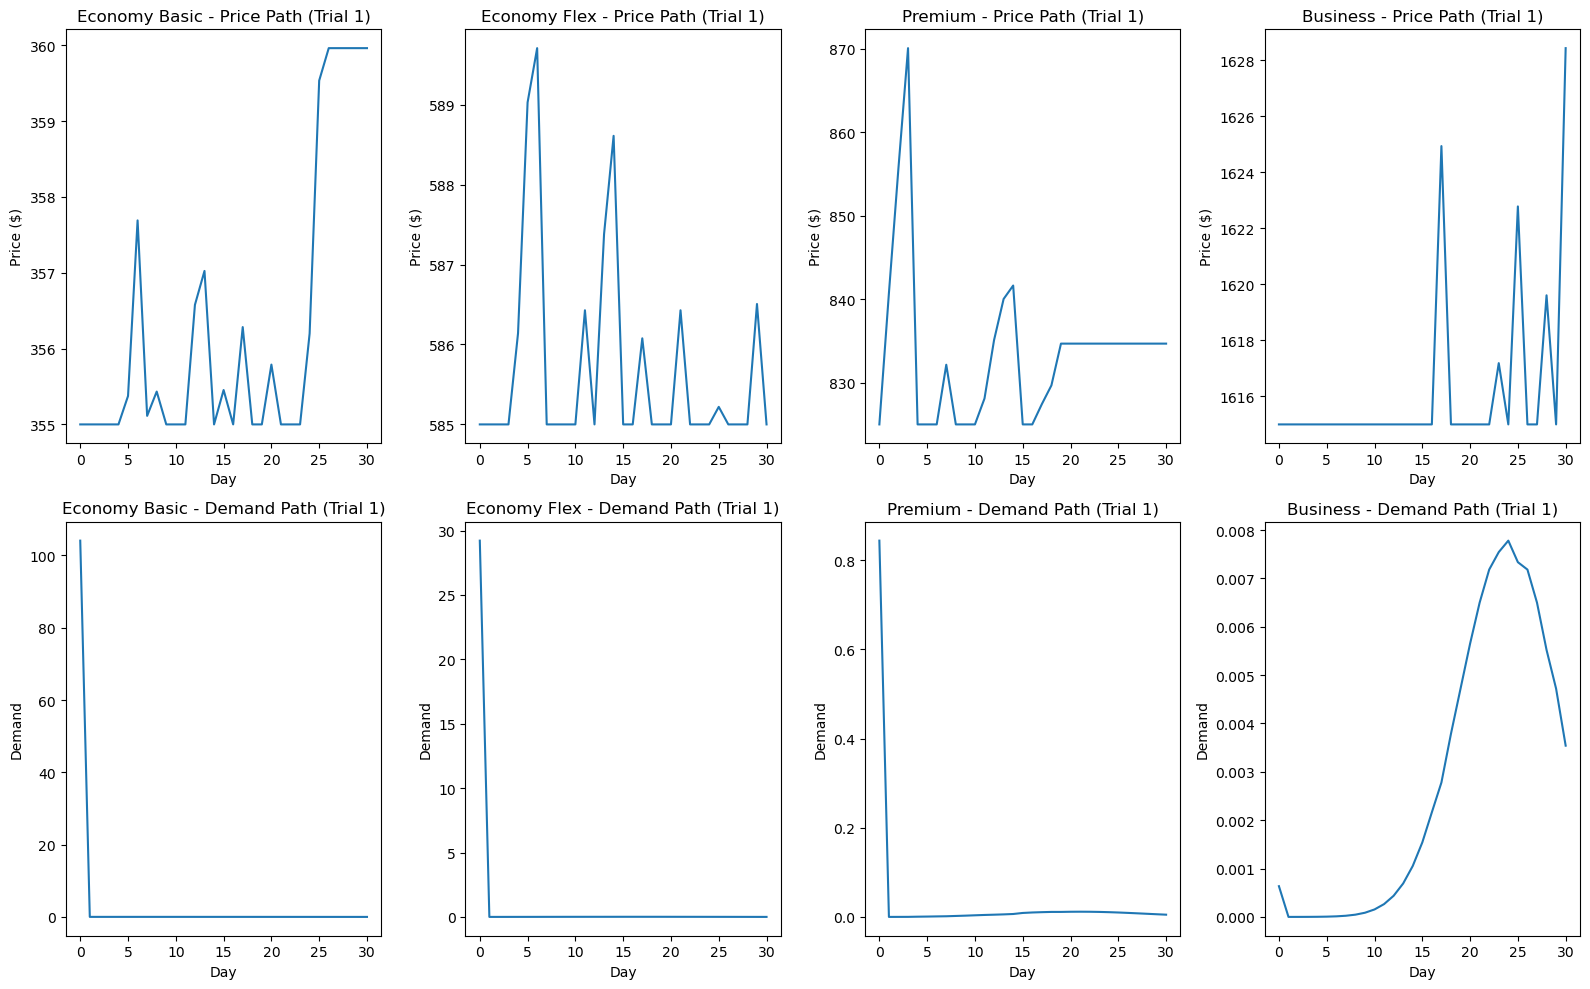

In [66]:
# --- Plot Price and Demand Paths for 1st Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")

plt.tight_layout()
plt.savefig("price_demand_paths_2.png")
plt.show()

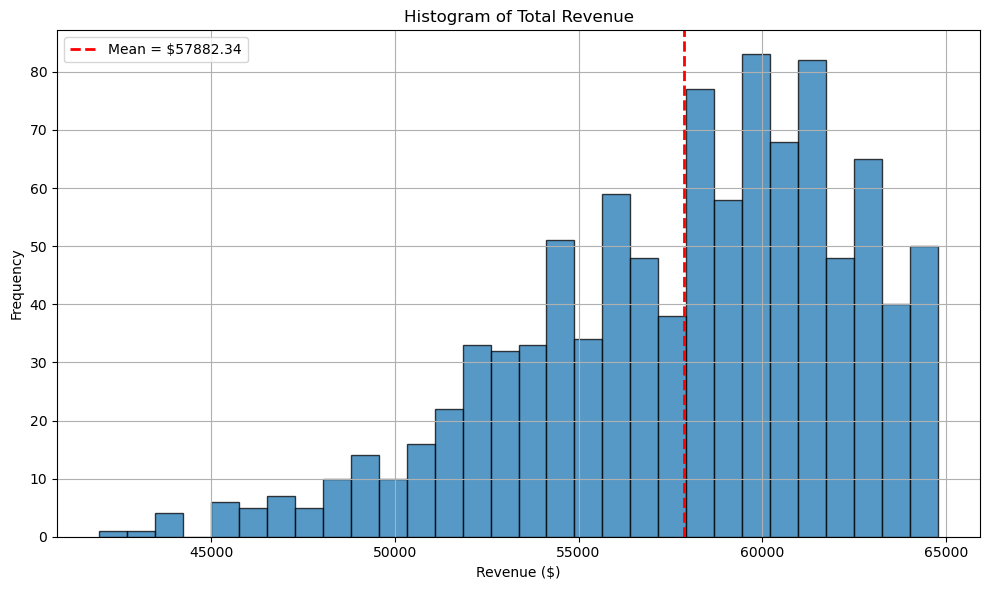

In [67]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_2.png")
plt.show()

Increasing the initial prices worked to prevent each of the ticket types from selling out every trial, increasing total revenue as well. However, the price movements in the given algorithm are sharp. We will adjust the thresholds so that prices aren't as sensitive to movement and examine the results.

In [68]:
#Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 355,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(120, 8, 15, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 585,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(90, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 825,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(50, 20, 7, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 1615,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(25, 23, 5, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
seats_sold_per_day = [[0 for _ in range(days_to_departure)] for _ in range(len(base_fare_buckets))]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial

# --- Price Adjustment ---
def adjust_price(bucket, actual, expected):
    if expected == 0:
        return
    pressure = actual / expected
    if pressure > 1.1:
        bucket["price"] *= 1 + alpha * np.log(pressure)
        bucket["price_increases"] += 1
    elif pressure < 0.98:
        bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))

In [69]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_1232/75288068.py:53: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $57841.23
Median Revenue: $58307.27
Std Dev Revenue: $4466.47

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 37.41, Avg Revenue = $13305.14
Economy Flex: Avg Tickets Sold = 27.66, Avg Revenue = $16211.75
Premium: Avg Tickets Sold = 18.49, Avg Revenue = $15283.29
Business: Avg Tickets Sold = 8.06, Avg Revenue = $13041.05


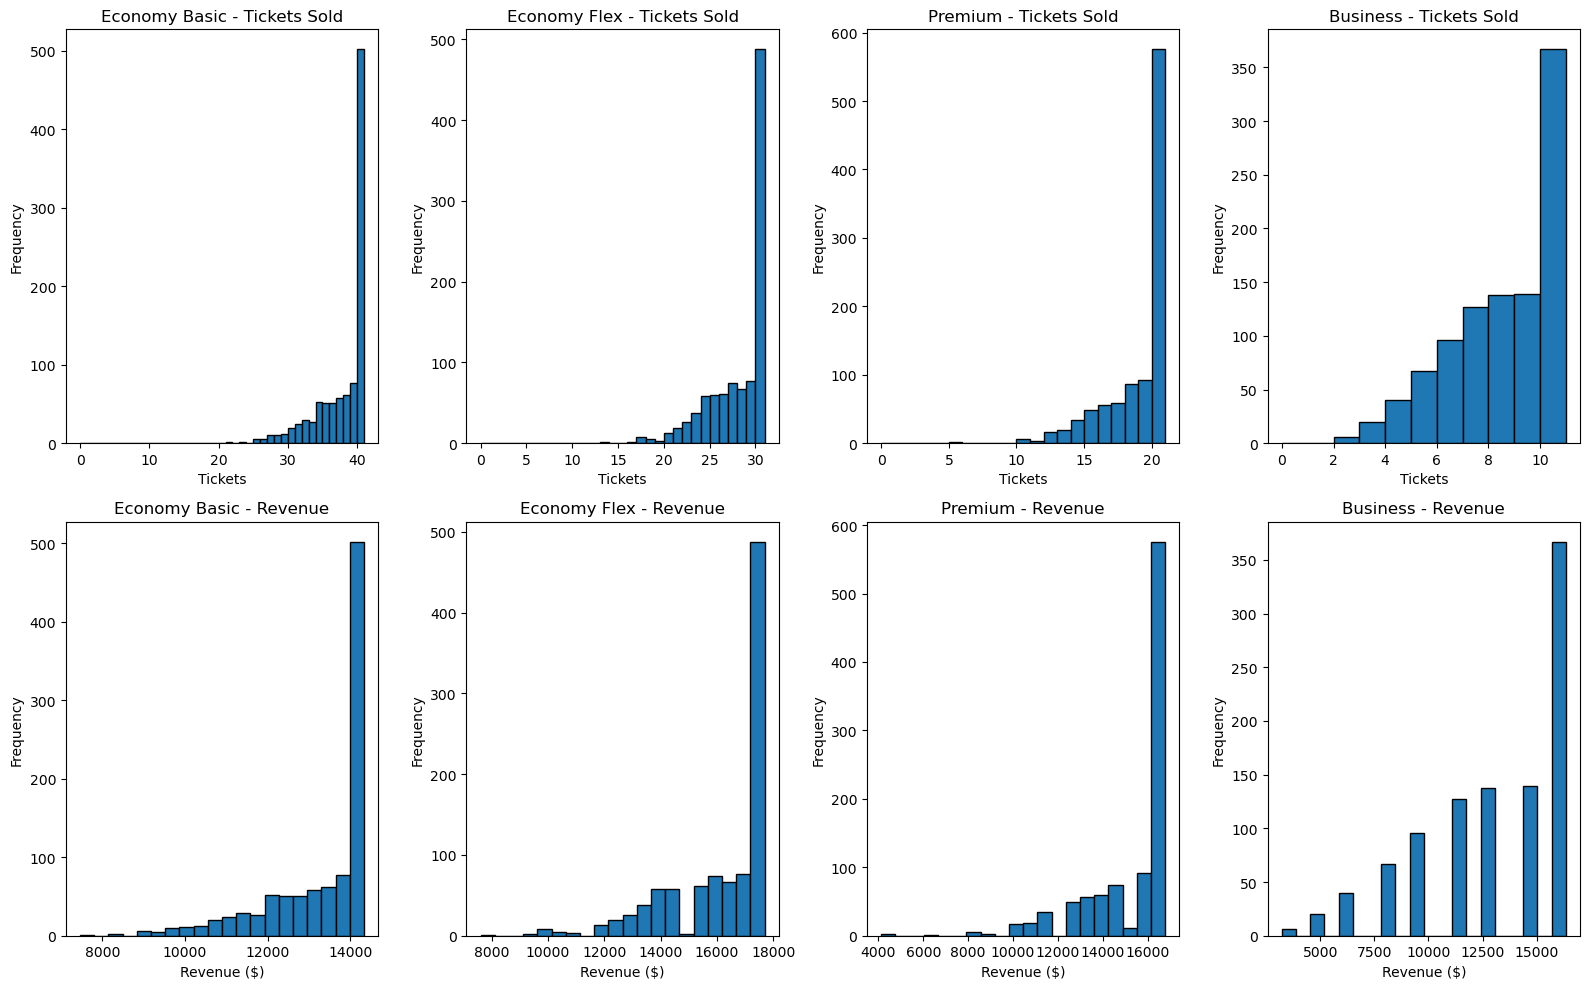

In [70]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_3.png")
plt.show()

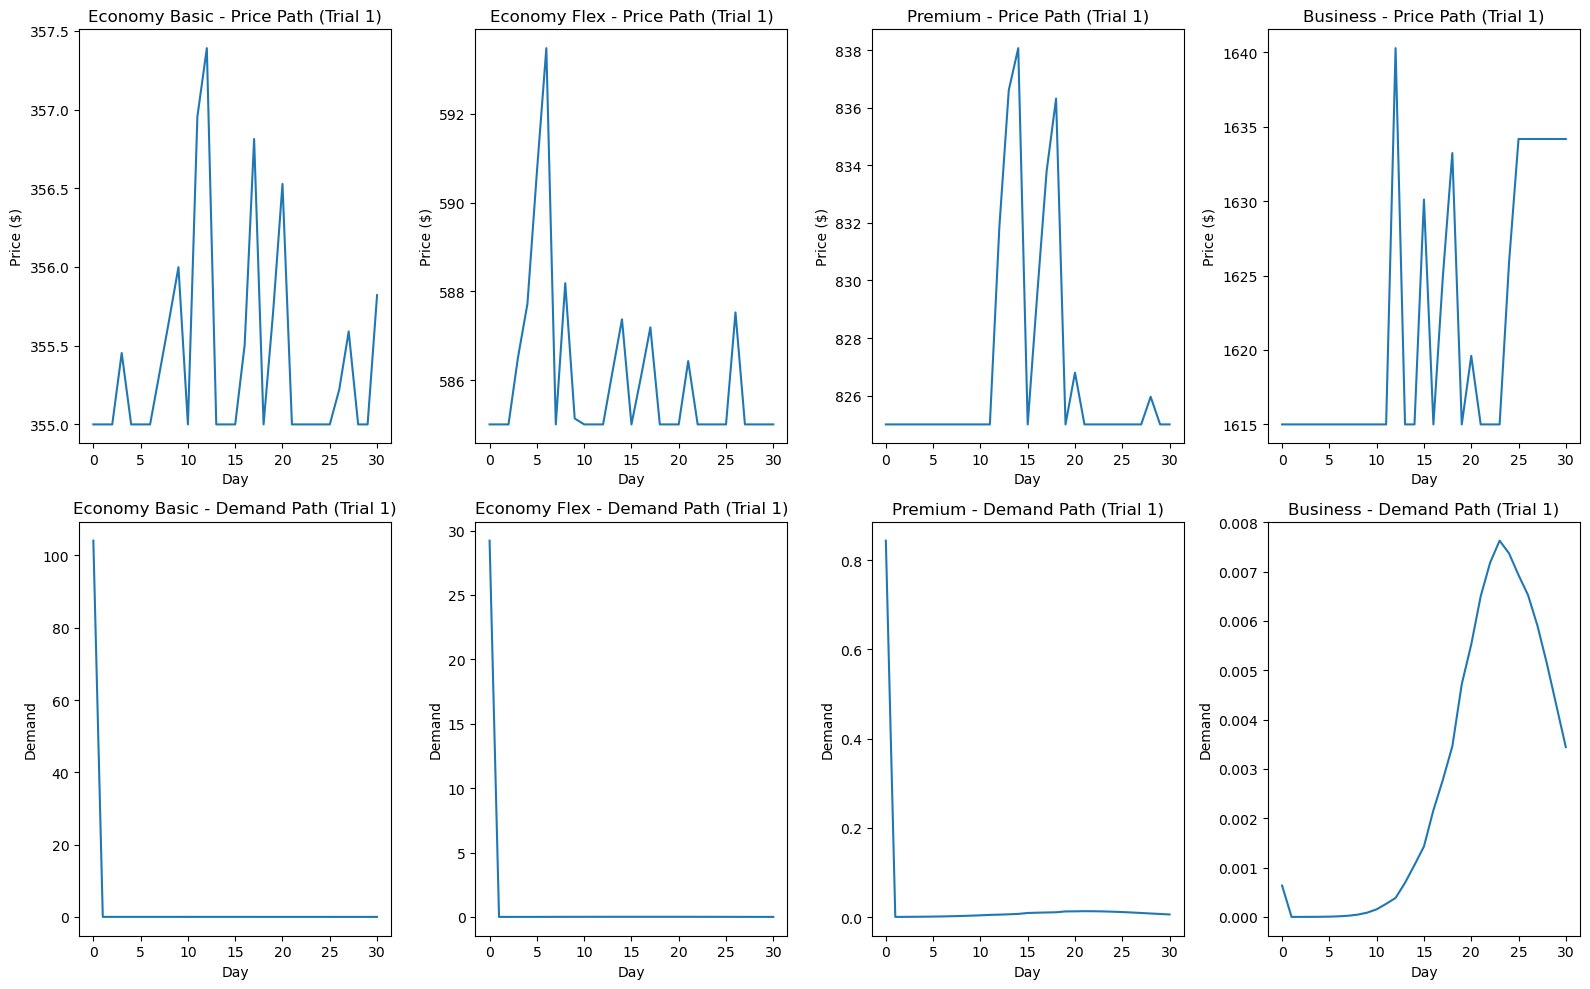

In [71]:
# --- Plot Price and Demand Paths for 100th Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")

plt.tight_layout()
plt.savefig("price_demand_paths_3.png")
plt.show()

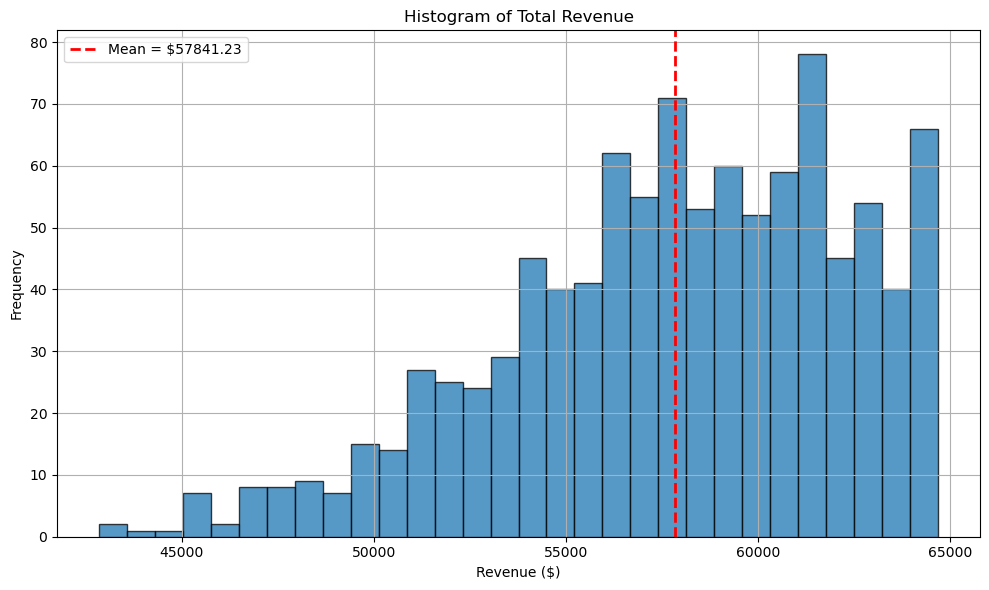

In [72]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_3.png")
plt.show()

As expected, this worked to keep prices from moving as dramatically each price shift, however it left average total revenue essentially the same. An alternative method to generating more casual price shifts is through decreasing our alpha value in our repricing algorithm. We will add this change to the previous model with the small target range for purchases per day.

In [73]:
# Setting alpha value
alpha = 0.001

#Fare Bucket Setup
base_fare_buckets = [
    {
        "label": "Economy Basic",
        "base_price": 355,
        "capacity": 40,
        "elasticity": 0.025,
        "base_demand_curve": [bell(120, 8, 15, day) for day in range(days_to_departure)]  # Demand curve function
    },
    {
        "label": "Economy Flex",
        "base_price": 585,
        "capacity": 30,
        "elasticity": 0.015,
        "base_demand_curve": [bell(90, 15, 10, day) for day in range(days_to_departure)] # Demand curve function
    },
    {
        "label": "Premium",
        "base_price": 825,
        "capacity": 20,
        "elasticity": 0.01,
        "base_demand_curve": [bell(50, 20, 7, day) for day in range(days_to_departure)]
    },
    {
        "label": "Business",
        "base_price": 1615,
        "capacity": 10,
        "elasticity": 0.005,
        "base_demand_curve": [bell(25, 23, 5, day) for day in range(days_to_departure)]  # Demand curve function
    }
]

bucket_labels = [b["label"] for b in base_fare_buckets]
num_buckets = len(base_fare_buckets)

# --- Trackers ---
total_revenues = []
fare_sales_all_trials = [[] for _ in base_fare_buckets]
fare_revenues_all_trials = [[] for _ in base_fare_buckets]
seats_sold_per_day = [[0 for _ in range(days_to_departure)] for _ in range(len(base_fare_buckets))]
price_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial
demand_paths_example_trial = [[] for _ in base_fare_buckets]  # for 1st trial

In [74]:
# --- Run Monte Carlo ---
for t in range(num_trials):
    run_simulation(track_prices=(t == 0))  # only track price path for 1st trial

# --- Summary Statistics ---
mean_revenue = np.mean(total_revenues)
median_revenue = np.median(total_revenues)
std_revenue = np.std(total_revenues)

print("=== Revenue Summary ===")
print(f"Mean Revenue: ${mean_revenue:.2f}")
print(f"Median Revenue: ${median_revenue:.2f}")
print(f"Std Dev Revenue: ${std_revenue:.2f}\n")

print("=== Fare Bucket Summary ===")
for i, label in enumerate(bucket_labels):
    mean_sold = np.mean(fare_sales_all_trials[i])
    mean_rev = np.mean(fare_revenues_all_trials[i])
    print(f"{label}: Avg Tickets Sold = {mean_sold:.2f}, Avg Revenue = ${mean_rev:.2f}")

/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_1232/75288068.py:53: RuntimeWarning: divide by zero encountered in log
  bucket["price"] = max(bucket["base_price"], bucket["price"] * (1 - alpha * (1 - np.log(pressure))))


=== Revenue Summary ===
Mean Revenue: $58001.17
Median Revenue: $58288.99
Std Dev Revenue: $4204.20

=== Fare Bucket Summary ===
Economy Basic: Avg Tickets Sold = 37.44, Avg Revenue = $13296.43
Economy Flex: Avg Tickets Sold = 27.84, Avg Revenue = $16290.40
Premium: Avg Tickets Sold = 18.62, Avg Revenue = $15369.03
Business: Avg Tickets Sold = 8.07, Avg Revenue = $13045.31


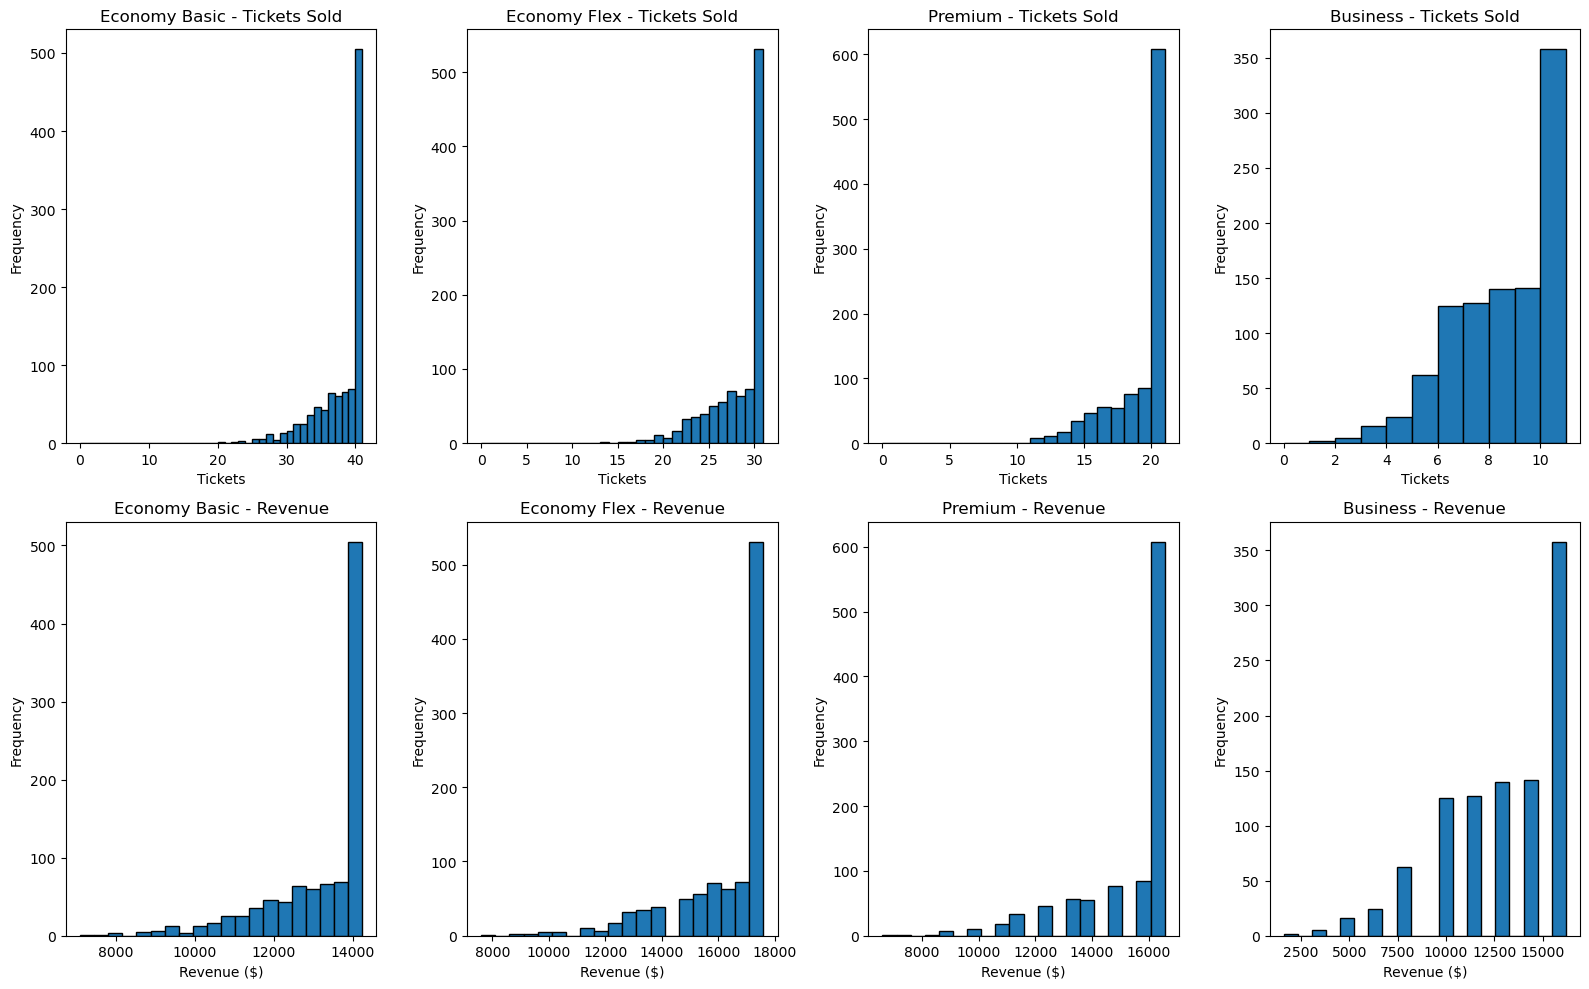

In [75]:
# --- Plot Histograms of Fare Bucket Revenues and Tickets Sold ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].hist(fare_sales_all_trials[i], bins=range(0, base_fare_buckets[i]["capacity"] + 2), edgecolor='black')
    axs[0, i].set_title(f"{label} - Tickets Sold")
    axs[0, i].set_xlabel("Tickets")
    axs[0, i].set_ylabel("Frequency")

    axs[1, i].hist(fare_revenues_all_trials[i], bins=20, edgecolor='black')
    axs[1, i].set_title(f"{label} - Revenue")
    axs[1, i].set_xlabel("Revenue ($)")
    axs[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("fare_bucket_histograms_4.png")
plt.show()

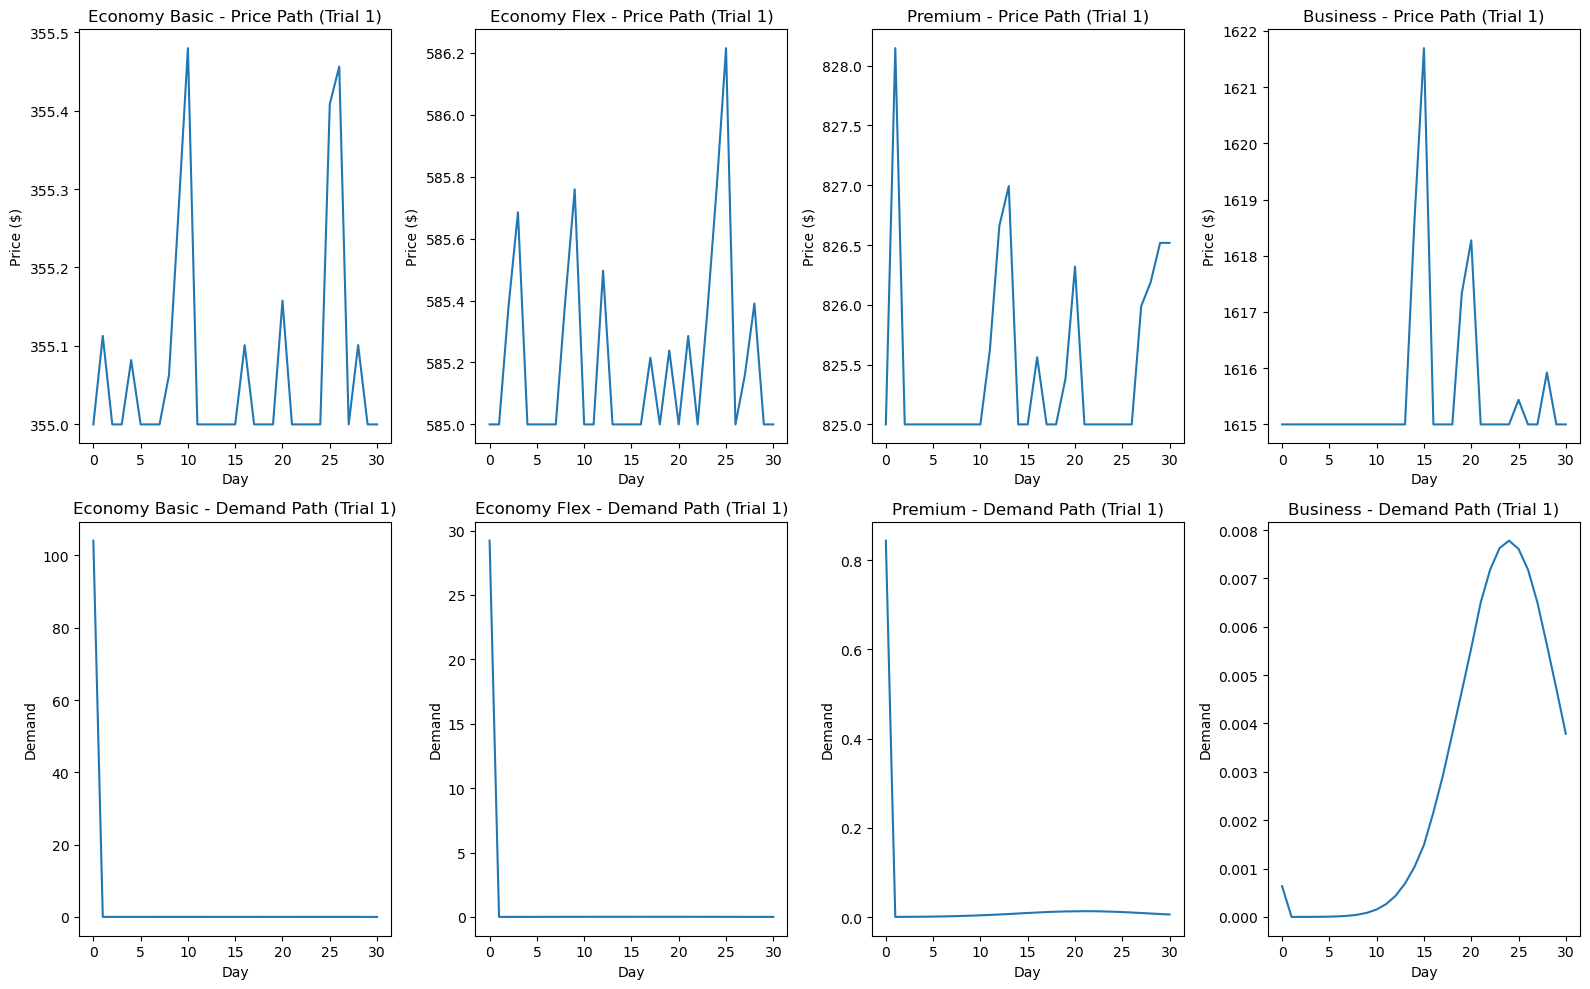

In [76]:
# --- Plot Price and Demand Paths for 100th Trial ---
fig, axs = plt.subplots(2, num_buckets, figsize=(4 * num_buckets, 10))
for i, label in enumerate(bucket_labels):
    axs[0, i].plot(price_paths_example_trial[i])
    axs[0, i].set_title(f"{label} - Price Path (Trial 1)")
    axs[0, i].set_xlabel("Day")
    axs[0, i].set_ylabel("Price ($)")

    axs[1, i].plot(demand_paths_example_trial[i])
    axs[1, i].set_title(f"{label} - Demand Path (Trial 1)")
    axs[1, i].set_xlabel("Day")
    axs[1, i].set_ylabel("Demand")

plt.tight_layout()
plt.savefig("price_demand_paths_4.png")
plt.show()

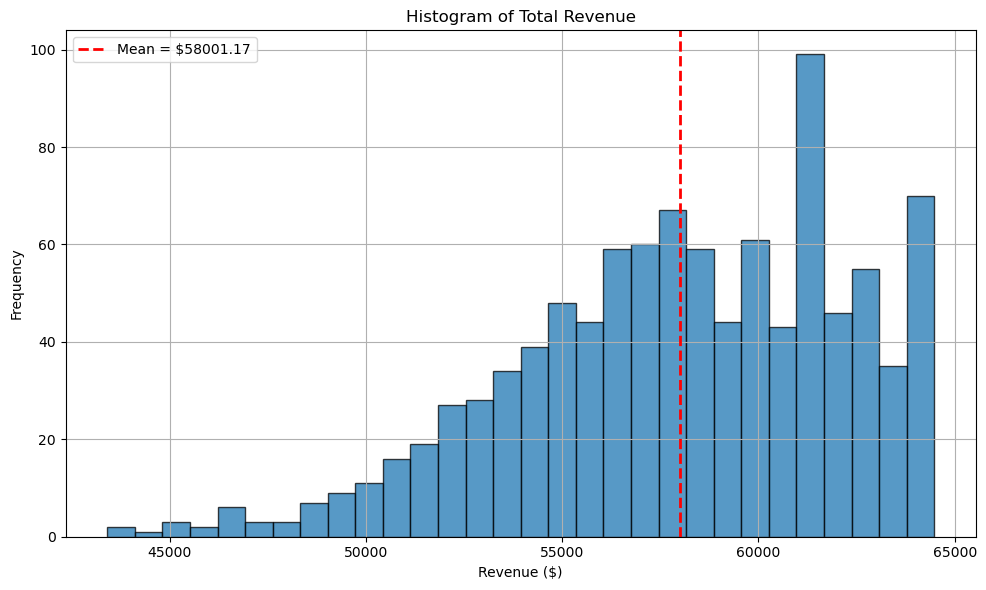

In [77]:
# Plotting revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenues, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f"Mean = ${mean_revenue:.2f}")

plt.title("Histogram of Total Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("revenue_histogram_4.png")
plt.show()

Once again, this change did little to alter the average total revenue generated. However, we did see less aggressive price shifts once again, as we were hoping for.

Because of the nature of the base demand curves we assumed for each fare bucket, the clear next step would be to design repricing algorithms for each of the fare types separately. On top of this, looking at actual flight data might give us clearer insights into how the demand for each ticket type vary as we approach the departure date.